# Evaluación de modelos de Machine Learning

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Métricas de evaluación

**DSLAB - Rubén Rodríguez Fernández**La evaluación de modelos de ML se efectua principalmente en dos ámbitos:

* Evaluación **offline** -> modelos no desplegados (e.g., selección de modelos y requisitos de negocio)
* Evaluación **online** -> modelos desplegados (e.g., métricas de negocio)

Además, estos dos ámbitos también pueden tener datos diferentes.

* En la evaluación offline, generalmente se utilizan datos **historicos**, con los que queremos caracterizar un determinado proceso.
* En la evaluación online, los datos suelen ser **"en vivo"**. 

Dependiendo del tipo de proceso que genera los datos "en vivo", tenemos dos escenarios:

* El proceso no cambia, y los datos pertenecen a la **misma distribución**.
* El proceso cambia, y por lo tanto, la distribución de los datos es **diferente**. Este cambio se denomina **concept drift**, y generalmente implica una degradación de los resultados del modelo.

Otro aspecto interesante a tener en cuenta es si el modelo desplegado afecta a la futura recogida de datos. Algunos ejemplos:

* Predicción de riesgo de muerte en una operación. Los pacientes con un alto riesgo podrían decir no operarse, haciendo que los nuevos datos pertenezcan a las clases de bajo riesgo.
* Predicción de impago de prestamos. Si los bancos no dan prestamos a clientes con bajo riesgo, la mayoría de los futuros datos pertenecerán a bajo riesgo.

En el primero de los casos, el modelo "quiere" que el paciente de alto riesgo se muera para confirmar que estaba en lo cierto. En el segundo caso el razonamiento es analogo.

Nos centraremos en la evaluación offline

## Evaluación offline

La evaluación offline nos permite seleccionar un modelo, así como determinar si ese modelo cumple los requisitos necesarios para desplegarlo en producción.

Dicha evaluación se realiza en diferentes conjuntos de datos dependiendo del objetivo de la misma. A priori, tenemos dos grupos principales:

* Conjunto de entrenamiento: Elección de modelo, optimización de hiperparámetros...
* Conjunto de test: Determinar si se cumplen los requisitos de negocio. Este conjunto de datos **solo** se utiliza justo antes de reportar, no se puede tomar **ninguna decisión** en base al resultado de estos datos. El objetivo es simular una puesta en producción. Esta evaluación es una estimación de la generalización del modelo a datos **nuevos**.


**NOTA**: A veces cuando tenemos pocos datos no se hace esta división (actualmente esto no suele ser un problema), y se utilizan técnicas como cross-validation o bootstrapping directamente sobre todo el conjunto de datos.

Hablando de la distribución de los conjuntos de train y test, ¿Tienen que ser iguales?

Respuesta rápida: **NO**. Tenemos que asegurarnos de que test solo contiene datos de la distribución de interés, ya que aquí tomaremos la decisión de si nuestro sistema es apto o no. En train podemos tener datos de distribuciones diferentes. Un ejemplo de esta situación es transfer learning.

¿Cómo realizo la división entre train y test?. El tipo de división depende de los datos:

* Datos tabulares: Se realiza de forma **aleatoria**.
![Holdout](data/evaluation/holdout.png)

* Datos con una estructura temporal: Se realizan **cortes temporales**. En la escala temporal, los datos de entrenamiento preceden a los de test. Sino se realizan cortes temporales, estaremos filtrando información de train a test, y los resultados de test serán sobreoptimistas.
![Holdout](data/evaluation/holdout_ts.png)

**NOTA**: En el caso de que las distribuciones sean diferentes, recordad que test **solo** debe contener datos de la distribución de interes.

¿Que tamaños deberían de tener estos conjuntos?

* Datasets muy pequeños: No realizar cortes (houldout) -> cross validation o bootstrapping.
* Datasets pequeños: 60-40
* Datasets medianos: 70-30 o 80-20
* Datasets grandes: 90-10
* Datasets muy grandes: 95-5

### Entrenamiento

* En general (salvo datasets muy pequeños) utilizaremos este dataset para seleccionar nuestro modelo y sus hiperparámetros tratando de maximizar una métrica.
* Pero si evaluamos nuestro modelo en entranamiento, podemos acabar teniendo una estimación de su desempeño sobreoptimista.
* **Posibles soluciones**: Crear otro nuevo conjunto de datos (validación, se realiza igual que train/test), cross-validation, boostraping.

**Cross-validation**

En datos tabulares:
* El modelo se entrena en k-1 grupos, y el grupo k se utiliza para evaluar el modelo
* Este se proceso se repite k veces (para evaluar el modeo en todos los folds)

En series temporales:
* El modelo se entrena en los folds $[1, \ldots, u)$ y se evalua en el fold $u$ ($\forall u \in 1, \ldots, k-1$)
* En total, se obtienen evaluaciones de los folds $(1, k]$. Del primer fold no obtenemos una evaluación.

Algunas variantes:
* LOOCV (leave-one-out cv): Se realiza cross-validation utilizando $k=\#\mathcal{D}$.
* LPOCV (leave-p-out cv): Similar a LOOCV, pero el modelo se prueba en todas las posibles formas de obtener P elementos a partir de $\mathcal{D}$. Es muy costoso computacionalmente, y no se suele realizar de forma exhaustiva.
* Repeated subsample selection: Se realizan, un número determinado de iteraciones, particiones de train y validación de forma aleatoria.

Se suele utilizar para selección y evaluación de modelos. En general no está sesgado y tiene una alta varianza.

![Holdout](data/evaluation/crossval.png)

**Boostraping en validación de modelos**

Bootstrap al igual que k-fold es una técnica de remuestreo. En este caso, se generan un número determinado de datasets (al igual que en k-fold). La diferencia, es que en boostrap estos datasets se generan utilizando remuestreo con remplazamiento (es decir, una misma observación puede aparecer más de una vez). 

* Boostrap simula nuevas observaciones muestreando de la distribución empirica (la distribución que hemos observado y debería representar el proceso subyacente). 
* Si hicieramos muestreo sin remplazo (no devolvemos las observaciones), estaríamos modificando la distribución empirica.
* Podemos entender las muestras repetidas como muestras similares en la población

Los estadisticos se miden en el dataset generado con boostrap ("en el dataset de train"). Aunque en algunas variaciones también se considera su valor en OOB.

Se suele utilizar como mecanismo para cuantificar la incertidumbre en el estadístico (e.g., standard error), y métodos de bagging. Esta sesgado y generalmente tiene poca varianza.

![Holdout](data/evaluation/boostrap.png)

**Curiosidad**: ¿Cuál es la probabilidad de que una observación aparezca en un dataset generado con boostraping?

* La probabilidad de elegir de forma aleatoria (distribución uniforme es $1/N$)
* Si la de un elemento $c$ es 1/N, la de cualquier elemento menos ese es $1 - 1/N$
* Entonces.. La probabilidad de que no salga $c$ al realizar N veces este proceso es $(1 - 1/N)^N$
* Y finalmente, la probabilidad de qeu aparezca $c$ es $1 - (1 - 1/N)^N$
* A medida que $N \to \infty$, la probabilidad es $1- e^{-1}$

In [39]:
real_prob = 1 - 1 / np.e

In [8]:
X = list(range(100))

In [9]:
def boostrap_sample(X, size, seed=42):
    random.seed(seed)
    return [random.choice(X) for _ in range(size)]

In [46]:
def calc_prob(X, iterations, obs):
    return sum(obs in boostrap_sample(X, size=len(X), seed=i) for i in range(iterations)) / iterations

In [47]:
obs = 42
iterations, prob = zip(*[(N, calc_prob(X, N, obs)) for N in range(10, 100_000, 1_000)])

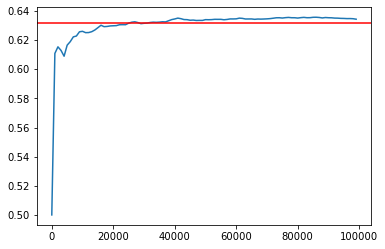

In [48]:
plt.plot(iterations, prob)
plt.axhline(real_prob, color='red')

In [113]:
np.random.seed(42)
Xn = np.random.normal(size=10_000)

In [114]:
def fast_boostrap_sample_mean(X, reps, seed=42):
    np.random.seed(seed)
    means = np.random.choice(Xn, size=(reps, len(Xn)), replace=True)
    return np.mean(means, axis=1)

In [115]:
boostrap_datasets = fast_boostrap_sample_mean(Xn, 10_000)

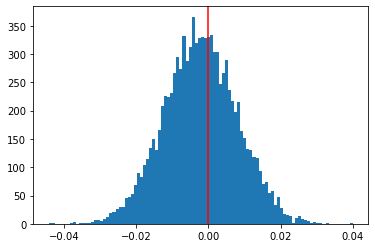

In [116]:
plt.hist(boostrap_datasets, bins=100);
plt.axvline(0.0, color='red')

In [117]:
iterations, boostrap_datasets_fmeans = zip(*[(N, np.mean(fast_boostrap_sample_mean(Xn, N))) for N in range(10, 10_000, 500)])

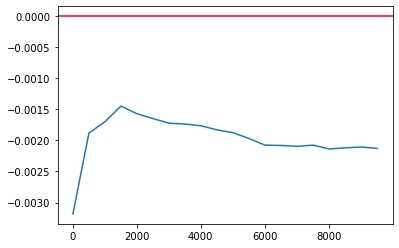

In [118]:
plt.plot(iterations, boostrap_datasets_fmeans)
plt.axhline(0, color='red')

## ¿Y qué métrica utilizamos para evaluar el modelo?

![errortypes](https://chemicalstatistician.files.wordpress.com/2014/05/pregnant.jpg?w=500&h=374)

Fuente: https://chemicalstatistician.files.wordpress.com/2014/05/pregnant.jpg?w=500&h=374


**Métricas de entrenamiento vs métricas de evaluación**

Generalmente la métrica que el modelo trata de optimizar no es la misma que la métrica que utilizamos para evaluar nuestro modelo.
Ejemplos:
* En la regresión lineal se trata de minimizar el error cuadratico medio (mse).
* En redes neuronales, en general se trata de minimizar la categorical cross entropy entre la distribución de las etiquetas originales y las predicciones. Nosotros "queremos" que sus distribuciones sean iguales (Ver Kullback-Leibler divergence, que es una medida de como dos distribuciones difieren)
* En redes bayesianas, generalmente se quiere obtener un MLE (Maximum likelihood estimation). De una forma no rigurosa, queremos buscar los parámetros de nuestra red bayesiana que sean mas probables bajo los datos observados.


**Comparación de métricas**

En general, no se puede comparar métricas diferentes entre si (incluso a veces la misma métrica en diferentes conjuntos de datos).

* Las métricas miden aspectos diferentes. Decir que un modelo A es mejor que uno B, porque el accuracy de A es mejor que el F1 score de B no tiene sentido.
* En general, no hay un valor para cada métrica a partir del cual el modelo se pueda considerar "bueno", y esto dependerá del dominio. Aunque si que hay algunos especiales. Por ejemplo:
    * Ningún modelo debería de tener un ROC AUC inferior a $0.5$. (http://arogozhnikov.github.io/2015/10/05/roc-curve.html)
    * Si tu métrica objetivo es el accuracy en un problema balanceado (50-50), si obtienes menos de $0.5$ quiere decir que estás "prediciendo del revés".
    * Si utilizas MCC, valores inferiores a $0$ también te dicen que estás "prediciendo del revés".

**¿Cuantas métricas??**

Deberíamos escoger **una sola métrica**. Esto nos facilitará tanto la selección automática como la manual de modelos. ¿Qué hacer si necesito considerar mas de una?:
* Juntar esas métricas en una. Por ejemplo, utilizando una media aritmetrica, geométrica, media ponderada...
* Establecer criterios de suficiencia. Por ejemplo, quiero maximizar el accuracy sujeto a tener un recall > 0.7.

# Lecturas recomendadas

* https://www.sciencedirect.com/science/article/pii/S0031320319300950

# Referencias

* https://www.oreilly.com/library/view/evaluating-machine-learning/9781492048756/